### Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Imports

In [4]:
import numpy as np
import pandas as pd

import os
import re
from pathlib import Path
import plotly.express as px

import tensorflow as tf

from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, LearningRateScheduler

import spacy
from unicodedata import normalize

#from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

#from livelossplot import PlotLossesKeras
import joblib
import json

from livelossplot import PlotLossesKeras

In [41]:
train = pd.read_csv('/content/drive/MyDrive/CS895_CleanDataCode/train_substructures_mordred2.csv')
#train = pd.read_csv('/content/drive/MyDrive/CS895_CleanDataCode/train_substructures_mordred.csv')
test = pd.read_csv('/content/drive/MyDrive/CS895_CleanDataCode/test_substructures_mordred2.csv')

In [74]:
test['label'].unique()

array([0, 4, 1, 3, 2])

In [100]:
train['label'].value_counts()

0    8862
4     631
2     417
1     241
3      64
Name: label, dtype: int64

In [43]:
train.head()

,text,drug1,drug2,ddi,type,label,smile1,smile2,pos1,pos2,...,JGI5.2,JGI5.3,JGI6,JGI6.1,JGI7,JGI7.1,JGI9.2,JGI9.3,WPath,WPath.1
0,The majority of patients in RA clinical studie...,MTX,azathioprine,False,Neg,0,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1O,CN1C=NC(=C1SC2=NC=NC3=C2NC=N3)[N+](=O)[O-],19,23,...,0.024288,0.024288,0.021341,0.021341,0.01686,0.01686,0.009808,0.009808,37337.0,37337.0
1,There were no reports of skeletal myopathy in ...,simvastatin,daptomycin,False,Neg,0,CCC(C)(C)C(=O)O[C@H]1C[C@H](C=C2[C@H]1[C@H]([C...,CCCCCCCCCC(=O)N[C@@H](CC1=CNC2=C1C=CC=C2)C(=O)...,20,26,...,0.024288,0.024288,0.021341,0.021341,0.01686,0.01686,0.009808,0.009808,37337.0,37337.0
2,DRUG1: Concomitant administration of DRUG2 (6 ...,Warfarin,daptomycin,False,Neg,0,CC(=O)CC(C1=CC=CC=C1)C2=C(C3=CC=CC=C3OC2=O)O,CCCCCCCCCC(=O)N[C@@H](CC1=CNC2=C1C=CC=C2)C(=O)...,0,4,...,0.024288,0.024288,0.021341,0.021341,0.01686,0.01686,0.009808,0.009808,37337.0,37337.0
3,"Before using this medication, tell your doctor...",aminoglycosides,cyclosporine,False,Neg,0,OC(=O)CCCCCCCC(O)=O,CC[C@H]1C(=O)N(CC(=O)N([C@H](C(=O)N[C@H](C(=O)...,20,25,...,0.024288,0.024288,0.021341,0.021341,0.01686,0.01686,0.009808,0.009808,37337.0,37337.0
4,DRUG1: Reports indicate that DRUG2 levels may ...,Cyclosporin,cyclosporine,False,Neg,0,CC[C@@H]1NC(=O)[C@H]([C@H](O)[C@H](C)C\C=C\C)N...,CC[C@H]1C(=O)N(CC(=O)N([C@H](C(=O)N[C@H](C(=O)...,0,4,...,0.024288,0.024288,0.021341,0.021341,0.01686,0.01686,0.009808,0.009808,37337.0,37337.0


In [48]:
train_df = train.drop(['text','drug1','drug2','smile1','smile2','ddi','type','pos1','pos2'], axis=1)
test_df = test.drop(['text','drug1','drug2','smile1','smile2','ddi','type','pos1','pos2'], axis=1)


In [ ]:
#test_df = test[['drug1_id','drug2_id','drug1_substructure','drug2_substructure','label']]

In [49]:
df = pd.concat([train_df, test_df], axis=0)
#df = train_df.copy()

In [50]:
df["drug1_substructure"] = df["drug1_substructure"].apply(lambda x: list(map(int, x.split(", "))))
df["drug2_substructure"] = df["drug2_substructure"].apply(lambda x: list(map(int, x.split(", "))))

### Padding

In [51]:
def padding(column):

  length = max([len(x) for x in column])
  padded_val =[]

  for val in column:

    if len(val) >= length:
      val = val[0:(length-1)]
    
    val[len(val): length] = [-1] * (length - len(val))

    padded_val.append(val)
  
  return padded_val

In [52]:
df["drug1_substructure"] = padding(df["drug1_substructure"])
df["drug2_substructure"] = padding(df["drug2_substructure"])

In [ ]:
# length = max([len(x) for x in train_df["drug2_substructure"]])
# for item in train_df["drug2_substructure"]:
#   if len(item) == length:
#     print(item)

### Taking X and Y

In [53]:
X = df.drop(['label'], axis=1)
y = df["label"].values

In [66]:
X.columns

Index(['drug1_id', 'drug2_id', 'drug1_substructure', 'drug2_substructure',
       'AATS0dv', 'AATS0dv.1', 'AATS0d', 'AATS0d.1', 'ATSC4dv', 'ATSC4dv.1',
       ...
       'JGI5.2', 'JGI5.3', 'JGI6', 'JGI6.1', 'JGI7', 'JGI7.1', 'JGI9.2',
       'JGI9.3', 'WPath', 'WPath.1'],
      dtype='object', length=196)

In [67]:
y

array([0, 0, 0, ..., 4, 1, 4])

### Splitting Data into Train/Test

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

### Unzipping X

In [55]:
unzip_x = lambda x: [np.vstack(x["drug1_substructure"]), np.vstack(x["drug2_substructure"])]

X_train, X_test = unzip_x(X_train), unzip_x(X_test)

In [56]:
drug1_length, drug2_length = len(X_train[0][0]), len(X_train[1][0])

### Model Building

In [57]:
def build_model(targets, drug1_length, drug2_length):

    # Loading the pre-trained Resnet model
    
    drug1_input = tf.keras.layers.Input(shape=drug1_length, name="input_drug1_Layer")
    
    drug2_input = tf.keras.layers.Input(shape=drug2_length, name="input_drug2_Layer")

    # Concat the results

    concat_vec = tf.keras.layers.concatenate([drug1_input, drug2_input], name="Concat")


    # x = tf.concat([x1, global_average_layer], axis=-1, name="Concat")

    # x = tf.keras.layers.Reshape(target_shape=((1, x.shape) + (1,)), name="Reshaping")(x)
    expanded_concat = tf.keras.layers.Reshape((concat_vec.shape[1], 1))(concat_vec)

    # print(expanded_concat)

    # # Encoder Layer
    x = tf.keras.layers.LSTM(128, return_sequences=True, return_state=True)(expanded_concat)
    x = tf.keras.layers.LSTM(128, return_sequences=True, return_state=True)(x)

    atten = tf.keras.layers.Attention()(x)

    dense = tf.keras.layers.Reshape(target_shape=(-1, 1))(atten)

    dense = tf.keras.layers.Flatten()(dense)

    print(dense.shape)

    # Output layer
    units = len(np.unique(targets))

    if units > 2:
        activation = "softmax"
        loss = "sparse_categorical_crossentropy"

    else:
        activation = "sigmoid"
        loss = "binary_crossentropy"
        units = units - 1

    outputs = Dense(units=units, activation=activation)(dense)

    print(outputs.shape)

    model = Model(inputs=[drug1_input, drug2_input], outputs=outputs)

    # Compiling the model
    model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])

    # Model Architecture Export
    tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, 
                            show_dtype=True, show_layer_names=True, rankdir='TB',
                            expand_nested=True, dpi=300, layer_range=None, 
                            show_layer_activations=True)


    return model

In [58]:
model = build_model(y_train, drug1_length, drug2_length)

(None, 49024)
(None, 5)


In [59]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_drug1_Layer (InputLayer)  [(None, 191)]       0           []                               
                                                                                                  
 input_drug2_Layer (InputLayer)  [(None, 192)]       0           []                               
                                                                                                  
 Concat (Concatenate)           (None, 383)          0           ['input_drug1_Layer[0][0]',      
                                                                  'input_drug2_Layer[0][0]']      
                                                                                                  
 reshape_2 (Reshape)            (None, 383, 1)       0           ['Concat[0][0]']           

In [60]:
def callbacks() -> list:

    run_name = "run 1"
    save_path = Path("/content/drive/MyDrive/CS895_CleanDataCode/models/onlytrain")
    os.makedirs(save_path/"logs", exist_ok=True)
    
    checkpoint = ModelCheckpoint(save_path, monitor="val_loss", save_best_only=True, 
                                                    verbose=1)

    earlystopping = EarlyStopping(monitor="val_loss", verbose=1, restore_best_weights = True,
                                                    patience=5)

    logger = TensorBoard(save_path/"logs"/run_name, histogram_freq=2, write_graph=True, write_images=True)

    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, verbose=1,
                                         min_delta=0.0001, cooldown=0, min_lr=0)
    
    return [checkpoint, earlystopping, lr, logger, PlotLossesKeras()]

### Model Training

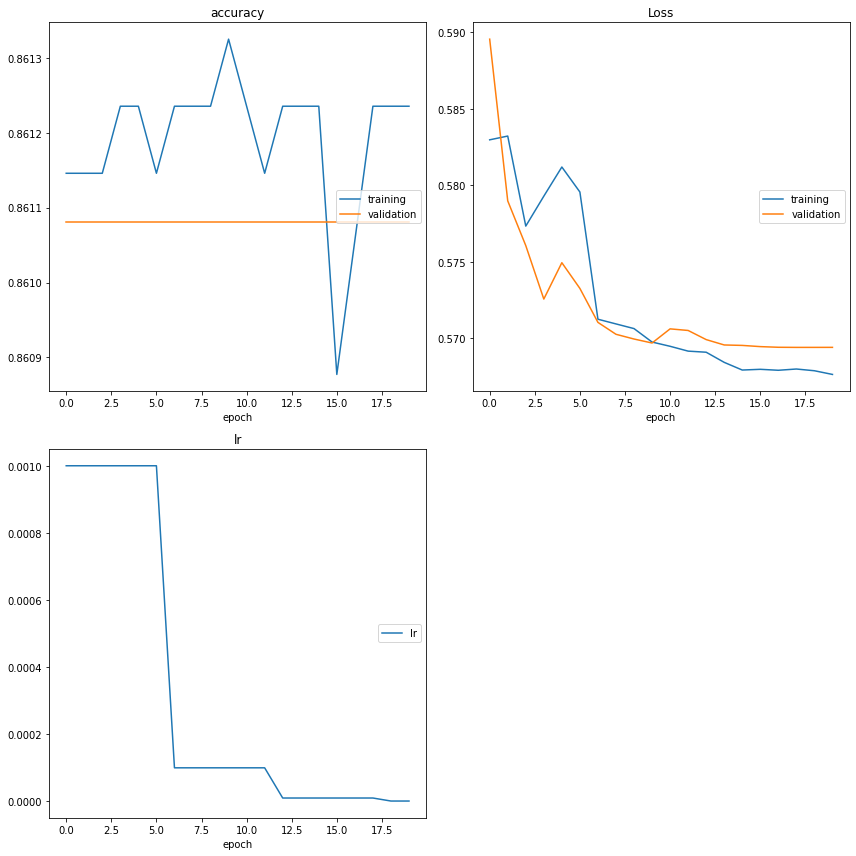

accuracy
	training         	 (min:    0.861, max:    0.861, cur:    0.861)
	validation       	 (min:    0.861, max:    0.861, cur:    0.861)
Loss
	training         	 (min:    0.568, max:    0.583, cur:    0.568)
	validation       	 (min:    0.569, max:    0.590, cur:    0.569)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
350/350 [==============================] - 341s 974ms/step - loss: 0.5676 - accuracy: 0.8612 - val_loss: 0.5694 - val_accuracy: 0.8611 - lr: 1.0000e-06


In [68]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=callbacks())

### Model Prediction

In [69]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/CS895_CleanDataCode/models/onlytrain")

In [94]:
y_pred_class = model.predict(X_test)

88/88 [==============================] - 27s 279ms/step


In [99]:
#pred = model.predict(padded)
y_pred_class

array([[0.8618357 , 0.02672311, 0.0415276 , 0.00800255, 0.06191115],
       [0.8618357 , 0.02672311, 0.0415276 , 0.00800255, 0.06191115],
       [0.8618357 , 0.02672311, 0.0415276 , 0.00800255, 0.06191115],
       ...,
       [0.8618356 , 0.0267231 , 0.0415276 , 0.00800255, 0.06191115],
       [0.8618356 , 0.0267231 , 0.0415276 , 0.00800255, 0.06191115],
       [0.8618356 , 0.0267231 , 0.0415276 , 0.00800255, 0.06191115]],
      dtype=float32)

In [90]:
#labels_test = np.argmax(y_test)


In [101]:
pred_test = np.argmax(y_pred_class, axis= -1)
#np.argmax(y_pred1,axis=1)

In [102]:
pred_test

array([0, 0, 0, ..., 0, 0, 0])

In [103]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_test)

array([[2405,    0,    0,    0,    0],
       [  75,    0,    0,    0,    0],
       [ 119,    0,    0,    0,    0],
       [  22,    0,    0,    0,    0],
       [ 172,    0,    0,    0,    0]])